In [2]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

ImportError: cannot import name 'Tensor' from 'torch' (unknown location)

### Styling Settings

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10

tqdm.pandas()


In [ ]:
# Random Seed Pytorch Lightning
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

## Load Data

In [ ]:
# Mouting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/Ửok/csv/processed_data_15min.csv"
df = pd.read_csv(data_path, parse_dates=["datetime"])
df

,datetime,Timestamp,PM2_5.ug.m3.,AQI.US.,AQI.CN.,PM10.ug.m3.,PM1.ug.m3.,Outdoor.AQI.US.,Outdoor.AQI.CN.,Temperature.C.,Temperature.F.,Humidity..RH.,CO2.ppm.
0,2024-06-27 15:45:00,1.719504e+09,2.0,7.9,2.9,2.1,1.0,0.0,0.0,24.5,76.1,76.0,799.4
1,2024-06-27 16:00:00,1.719504e+09,2.0,7.9,2.9,2.0,1.0,0.0,0.0,24.7,76.4,75.0,823.1
2,2024-06-27 16:15:00,1.719505e+09,2.0,7.8,2.9,2.0,1.0,0.0,0.0,24.7,76.5,72.8,835.1
3,2024-06-27 16:30:00,1.719506e+09,1.7,6.9,2.4,1.8,0.7,0.0,0.0,24.8,76.7,72.0,850.2
4,2024-06-27 16:45:00,1.719507e+09,1.6,6.4,2.2,1.6,0.6,0.0,0.0,24.8,76.7,71.0,858.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17565,2024-12-27 15:00:00,1.735312e+09,23.6,75.2,33.7,26.1,18.6,0.0,0.0,24.8,76.6,56.0,608.4
17566,2024-12-27 15:15:00,1.735313e+09,23.3,74.6,33.2,25.3,18.3,0.0,0.0,24.8,76.6,56.0,587.0
17567,2024-12-27 15:30:00,1.735314e+09,22.5,73.0,32.0,24.7,17.6,0.0,0.0,24.8,76.7,55.8,585.6
17568,2024-12-27 15:45:00,1.735315e+09,21.7,71.4,30.8,23.9,17.3,0.0,0.0,24.8,76.6,56.0,610.3


In [ ]:
df.columns

Index(['datetime', 'Timestamp', 'PM2_5.ug.m3.', 'AQI.US.', 'AQI.CN.',
       'PM10.ug.m3.', 'PM1.ug.m3.', 'Outdoor.AQI.US.', 'Outdoor.AQI.CN.',
       'Temperature.C.', 'Temperature.F.', 'Humidity..RH.', 'CO2.ppm.'],
      dtype='object')

In [ ]:
# Global variables
model = None
train_loader = None
test_loader = None
scaler = None
device = None
train_losses = None
test_losses = None
train_predictions = None
train_actuals = None
test_predictions = None
test_actuals = None

# Model hyperparameters
sequence_length = 24  # 6 hours with 15-min intervals
input_size = 3      # PM2.5, PM10, PM1
hidden_size = 50
num_layers = 2
dropout = 0.2
learning_rate = 0.001
num_epochs = 50
batch_size = 32

# Pre-Processing Data

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
def prepare_multivariate_data(df, sequence_length=24, train_split=0.8, batch_size=32):
    global train_loader, test_loader, scaler

    features = ['PM2_5.ug.m3.', 'PM10.ug.m3.', 'PM1.ug.m3.']

    # Handle missing values
    df_selected = df[features].copy().interpolate(method='linear')

    # Split data FIRST to prevent leakage
    train_size = int(len(df_selected) * train_split)
    train_data = df_selected.iloc[:train_size]
    test_data = df_selected.iloc[train_size:]

    # Scale data properly (fit only on training data)
    scaler = MinMaxScaler().fit(train_data)  # FIXED: No leakage
    scaled_train = scaler.transform(train_data)
    scaled_test = scaler.transform(test_data)

    # Create sequences for both sets
    def create_sequences(data):
        X, y = [], []
        for i in range(len(data) - sequence_length):
            X.append(data[i:(i + sequence_length)])
            y.append(data[i + sequence_length, :])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(scaled_train)
    X_test, y_test = create_sequences(scaled_test)

    # Create DataLoaders
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class MultivariatePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.linear = nn.Linear(hidden_size, 3)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step = lstm_out[:, -1, :]
        return self.linear(last_time_step)

In [ ]:
def train_model(df):
    global model, device, train_losses, test_losses

    # Set device and random seed
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.manual_seed(42)
    print(f"Using device: {device}")

    # Prepare data
    prepare_multivariate_data(
        df,
        sequence_length=sequence_length,
        batch_size=batch_size
    )

    # Initialize model
    model = MultivariatePredictor(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                test_loss += criterion(outputs, batch_y).item()

        # Record losses
        train_losses.append(train_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '  # FIXED: Corrected f-string
            f'Train Loss: {train_losses[-1]:.4f}, '
            f'Test Loss: {test_losses[-1]:.4f}')

In [ ]:
def make_predictions():
    global train_predictions, train_actuals, test_predictions, test_actuals
    model.eval()

    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            # Reshape predictions to match scaler's expected format
            predictions_array = outputs.cpu().numpy()
            actuals_array = batch_y.numpy()
            predictions.extend(predictions_array)
            actuals.extend(actuals_array)

    train_predictions = np.array(predictions)
    train_actuals = np.array(actuals)

    # Make test predictions with the same reshape approach
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions_array = outputs.cpu().numpy()
            actuals_array = batch_y.numpy()
            predictions.extend(predictions_array)
            actuals.extend(actuals_array)

    test_predictions = np.array(predictions)
    test_actuals = np.array(actuals)

    # Reshape predictions to match feature order: PM2.5, PM10, PM1
    feature_order = ['PM2_5.ug.m3.', 'PM10.ug.m3.', 'PM1.ug.m3.']

    # Create arrays that match the scaler's format
    train_predictions_reshaped = train_predictions.reshape(-1, len(feature_order))
    train_actuals_reshaped = train_actuals.reshape(-1, len(feature_order))
    test_predictions_reshaped = test_predictions.reshape(-1, len(feature_order))
    test_actuals_reshaped = test_actuals.reshape(-1, len(feature_order))

    # Inverse transform the reshaped arrays
    train_predictions = scaler.inverse_transform(train_predictions_reshaped)
    train_actuals = scaler.inverse_transform(train_actuals_reshaped)
    test_predictions = scaler.inverse_transform(test_predictions_reshaped)
    test_actuals = scaler.inverse_transform(test_actuals_reshaped)

In [ ]:
def calculate_metrics():
    parameter_names = ['PM2.5', 'PM10', 'PM1']
    epsilon = 1e-7  # Small constant to avoid division by zero
    for i, param in enumerate(parameter_names):
        # Calculate RMSE
        train_rmse = np.sqrt(((train_predictions[:, i] - train_actuals[:, i]) ** 2).mean())
        test_rmse = np.sqrt(((test_predictions[:, i] - test_actuals[:, i]) ** 2).mean())

        # Calculate MAE
        train_mae = np.abs(train_predictions[:, i] - train_actuals[:, i]).mean()
        test_mae = np.abs(test_predictions[:, i] - test_actuals[:, i]).mean()


        # Calculate R squared coefficient
        train_r2 = 1 - np.sum((train_actuals[:, i] - train_predictions[:, i]) ** 2) / (np.sum((train_actuals[:, i] - np.mean(train_actuals[:, i])) ** 2) + epsilon)
        test_r2 = 1 - np.sum((test_actuals[:, i] - test_predictions[:, i]) ** 2) / (np.sum((test_actuals[:, i] - np.mean(test_actuals[:, i])) ** 2) + epsilon)

        print(f"\nMetrics for {param}:")
        print(f"Training RMSE: {train_rmse:.2f}")
        print(f"Test RMSE: {test_rmse:.2f}")
        print(f"Training MAE: {train_mae:.2f}")
        print(f"Test MAE: {test_mae:.2f}")
        print(f"Training R²: {train_r2:.2f}")
        print(f"Test R²: {test_r2:.2f}")

In [ ]:
# Train the model
train_model(df)

# Generate predictions
make_predictions()

# Calculate and display metrics
calculate_metrics()

Using device: cpu
Epoch [10/50], Train Loss: 0.0002, Test Loss: 0.0001
Epoch [20/50], Train Loss: 0.0001, Test Loss: 0.0001
Epoch [30/50], Train Loss: 0.0001, Test Loss: 0.0001
Epoch [40/50], Train Loss: 0.0001, Test Loss: 0.0001
Epoch [50/50], Train Loss: 0.0001, Test Loss: 0.0001

Metrics for PM2.5:
Training RMSE: 1.22
Test RMSE: 1.45
Training MAE: 0.66
Test MAE: 1.08
Training MAPE: 6.80%
Test MAPE: 4.73%
Training R²: 0.99
Test R²: 0.99

Metrics for PM10:
Training RMSE: 1.47
Test RMSE: 1.63
Training MAE: 0.74
Test MAE: 1.25
Training MAPE: 6.78%
Test MAPE: 5.31%
Training R²: 0.99
Test R²: 0.99

Metrics for PM1:
Training RMSE: 1.03
Test RMSE: 0.95
Training MAE: 0.56
Test MAE: 0.60
Training MAPE: 2321942.58%
Test MAPE: 4.04%
Training R²: 0.99
Test R²: 0.99


In [ ]:
calculate_metrics()


Metrics for PM2.5:
Training RMSE: 1.22
Test RMSE: 1.45
Training MAE: 0.66
Test MAE: 1.08
Training R²: 0.99
Test R²: 0.99

Metrics for PM10:
Training RMSE: 1.47
Test RMSE: 1.63
Training MAE: 0.74
Test MAE: 1.25
Training R²: 0.99
Test R²: 0.99

Metrics for PM1:
Training RMSE: 1.03
Test RMSE: 0.95
Training MAE: 0.56
Test MAE: 0.60
Training R²: 0.99
Test R²: 0.99


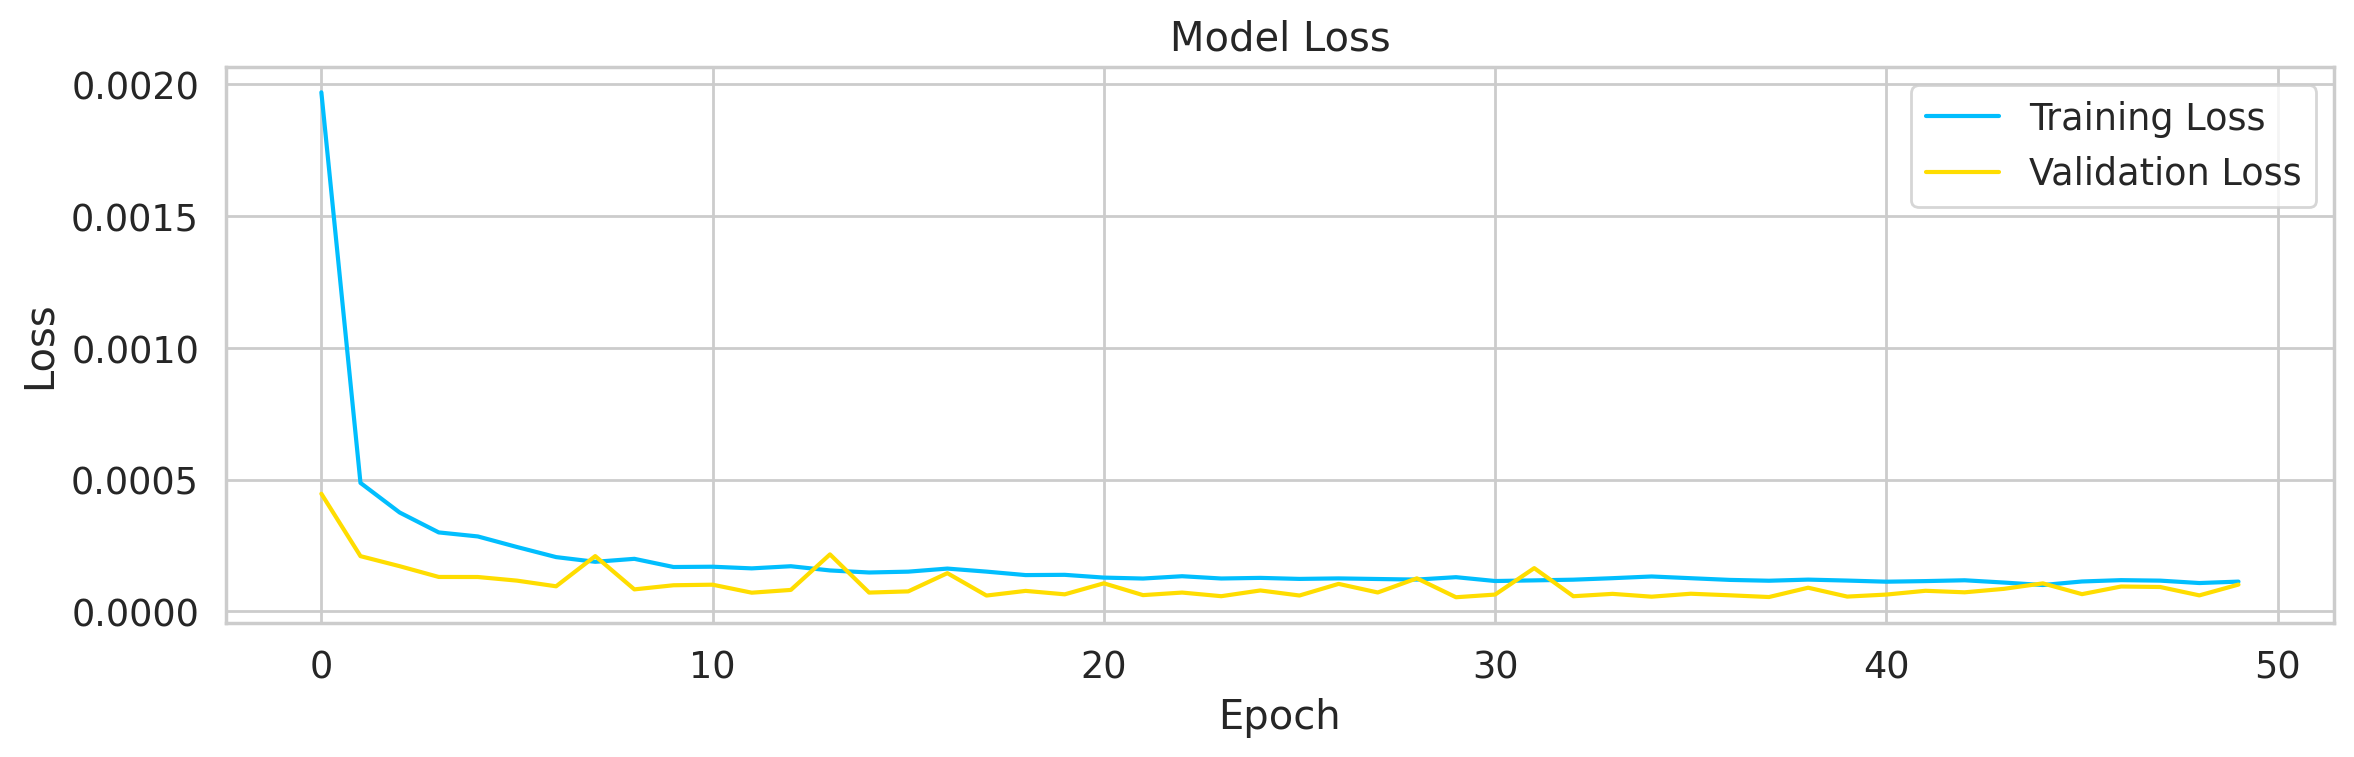

In [ ]:
# Plot results
plt.figure(figsize=(12, 4))

# Plot losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


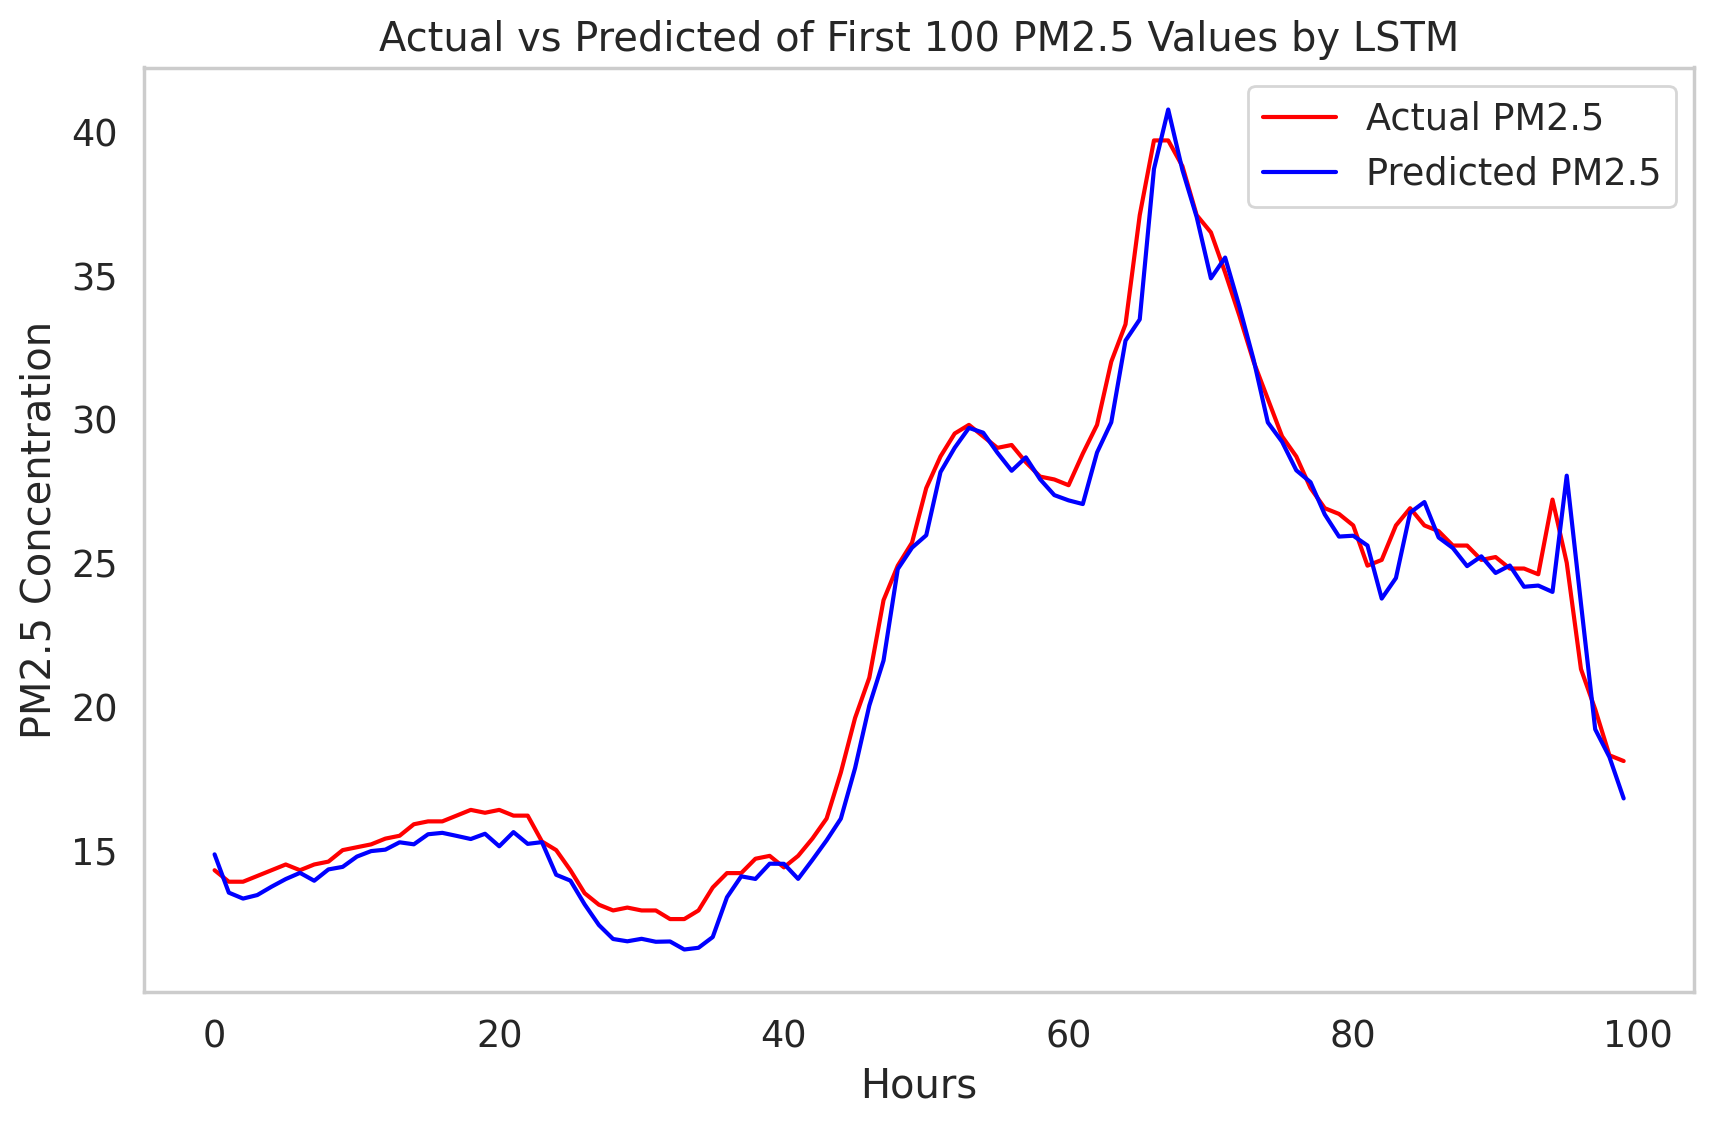

In [ ]:
def plot_pm25(test_actuals, test_predictions, data_points):
    plt.figure(figsize=(10, 6))
    plt.plot(test_actuals[:100, 0], label='Actual PM2.5', color='red')
    plt.plot(test_predictions[:100, 0], label='Predicted PM2.5', color='blue')
    plt.title(f'Actual vs Predicted of First {data_points} PM2.5 Values by LSTM')
    plt.xlabel('Hours')
    plt.ylabel('PM2.5 Concentration')
    plt.legend()
    plt.grid(False)
    plt.show()

plot_pm25(test_actuals, test_predictions, data_points=100)

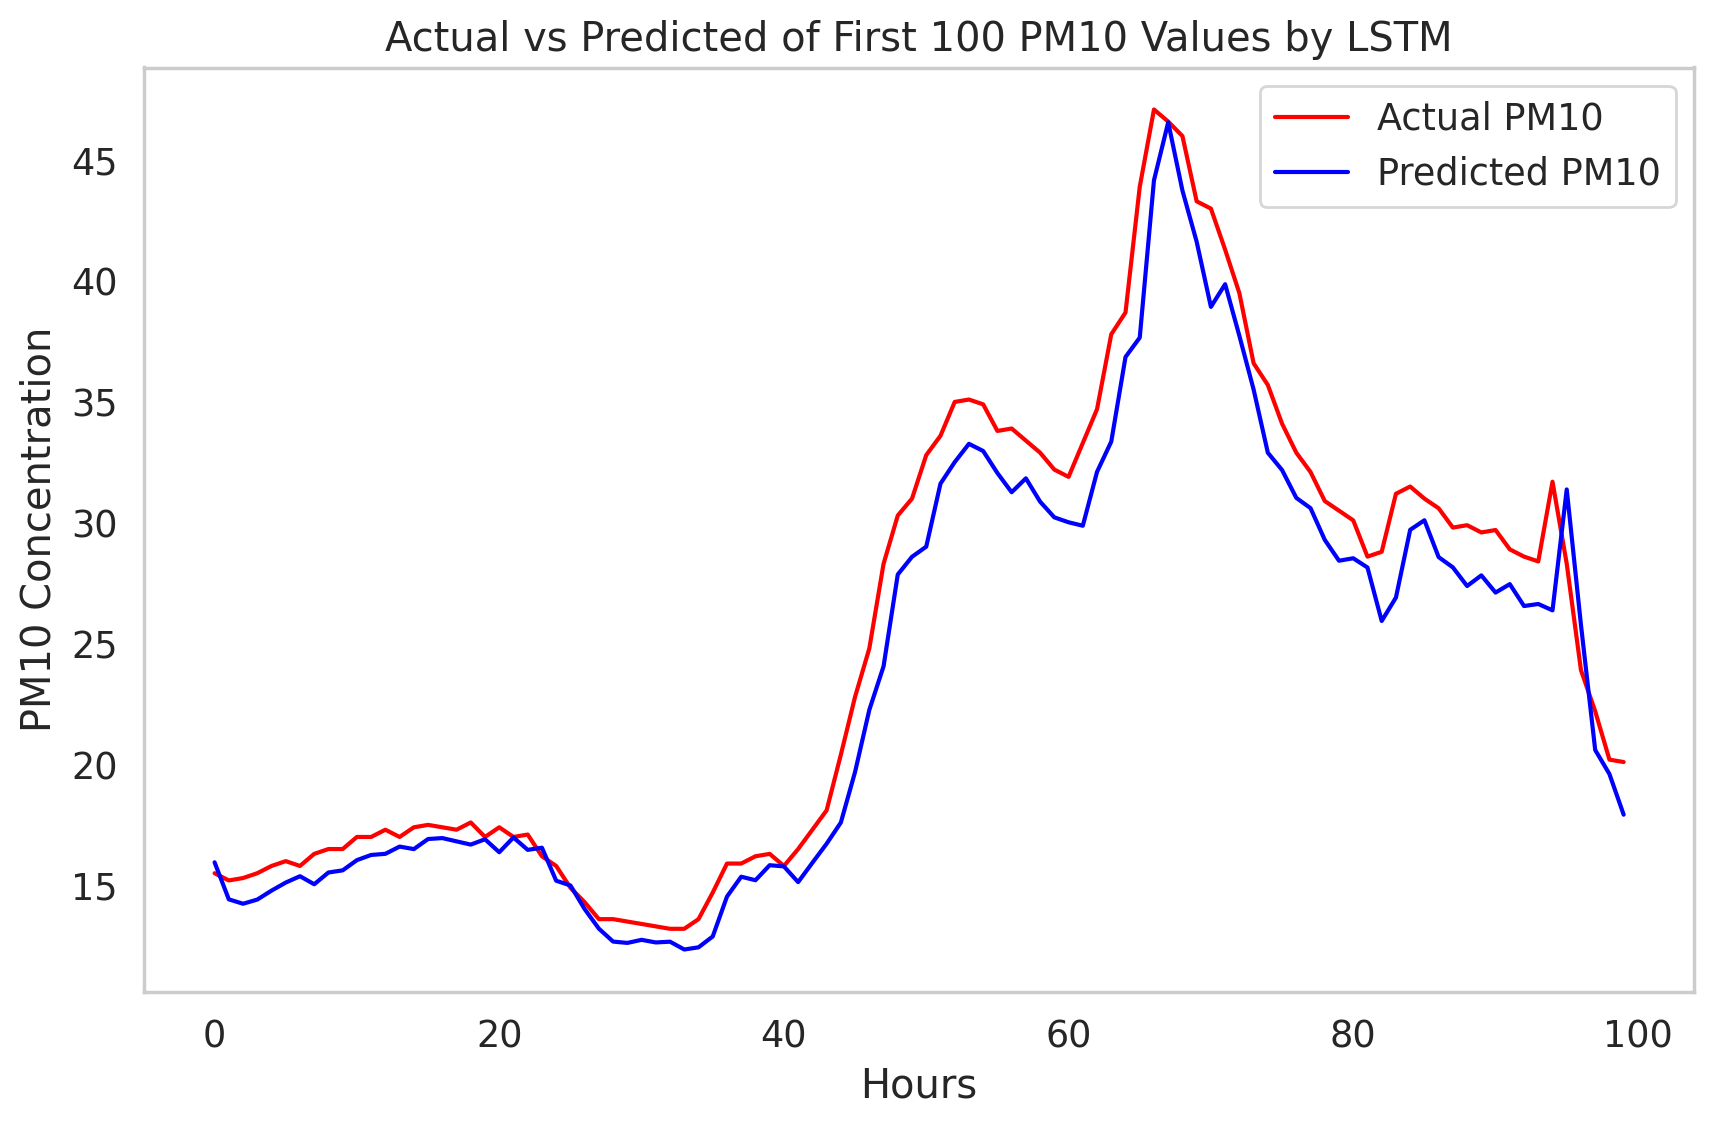

In [ ]:
def plot_pm10(test_actuals, test_predictions, data_points):
    plt.figure(figsize=(10, 6))
    plt.plot(test_actuals[:100, 1], label='Actual PM10', color='red')
    plt.plot(test_predictions[:100, 1], label='Predicted PM10', color='blue')
    plt.title(f'Actual vs Predicted of First {data_points} PM10 Values by LSTM')
    plt.xlabel('Hours')
    plt.ylabel('PM10 Concentration')
    plt.legend()
    plt.grid(False)
    plt.show()

plot_pm10(test_actuals, test_predictions, data_points=100)

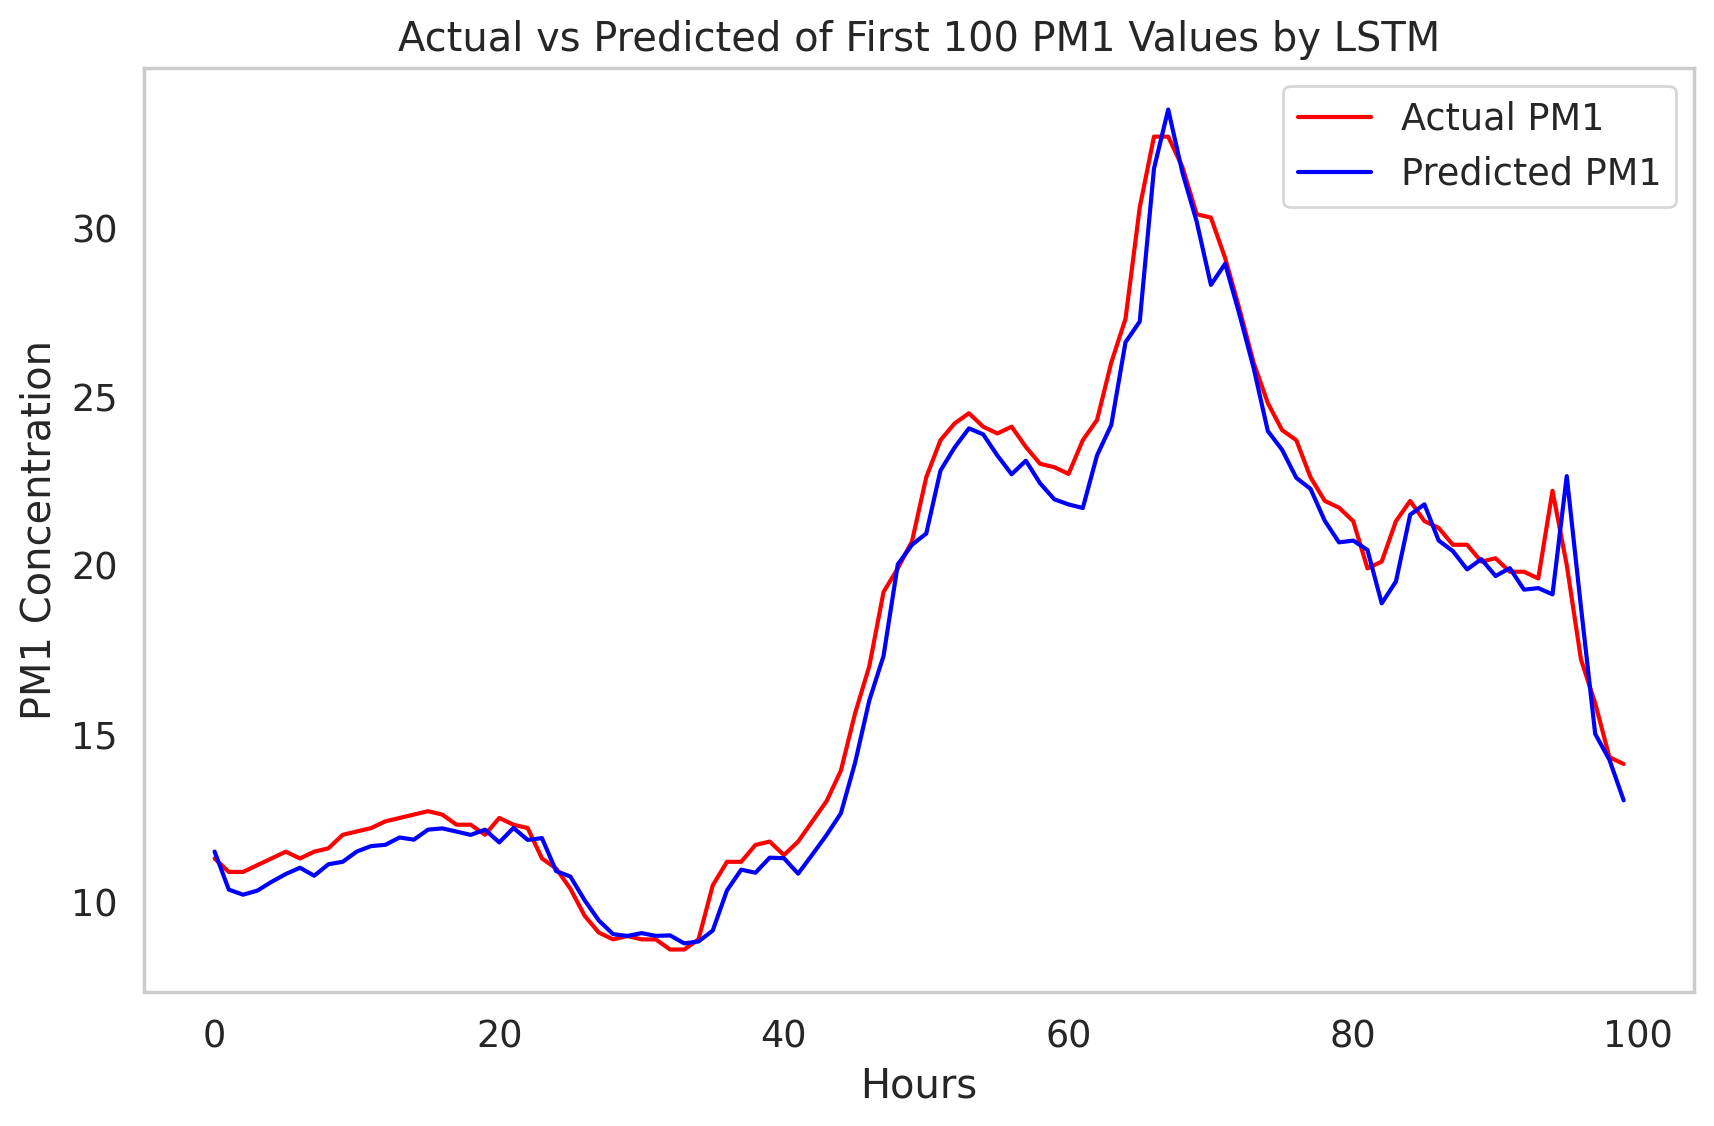

In [ ]:
def plot_pm1(test_actuals, test_predictions, data_points):
    plt.figure(figsize=(10, 6))
    plt.plot(test_actuals[:100, 2], label='Actual PM1', color='red')
    plt.plot(test_predictions[:100, 2], label='Predicted PM1', color='blue')
    plt.title(f'Actual vs Predicted of First {data_points} PM1 Values by LSTM')
    plt.xlabel('Hours')
    plt.ylabel('PM1 Concentration')
    plt.legend()
    plt.grid(False)
    plt.show()

plot_pm1(test_actuals, test_predictions, data_points=100)